In [170]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.utils.data as Data
%matplotlib inline

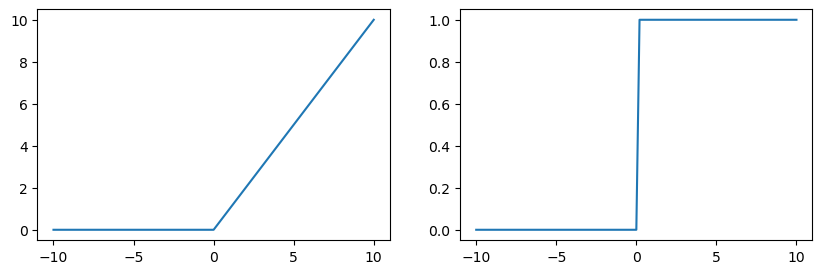

In [171]:
x = torch.linspace(-10, 10, 101)
x.requires_grad = True
y = x.relu()
z = y.sum()
z.backward()
plt.subplots(1, 2, figsize=(10, 3))
plt.subplot(1, 2, 1) ; plt.plot(x.detach(), y.detach())
plt.subplot(1, 2, 2) ; plt.plot(x.detach(), x.grad.detach())

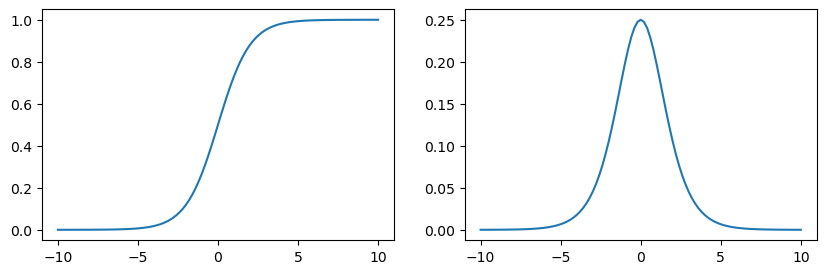

In [172]:
x = torch.linspace(-10, 10, 101)
x.requires_grad = True
y = x.sigmoid()
z = y.sum()
z.backward()
plt.subplots(1, 2, figsize=(10, 3))
plt.subplot(1, 2, 1) ; plt.plot(x.detach(), y.detach())
plt.subplot(1, 2, 2) ; plt.plot(x.detach(), x.grad.detach())

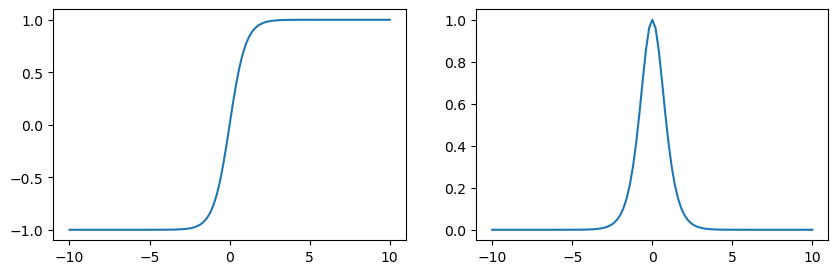

In [173]:
x = torch.linspace(-10, 10, 101)
x.requires_grad = True
y = x.tanh()
z = y.sum()
z.backward()
plt.subplots(1, 2, figsize=(10, 3))
plt.subplot(1, 2, 1) ; plt.plot(x.detach(), y.detach())
plt.subplot(1, 2, 2) ; plt.plot(x.detach(), x.grad.detach())

In [174]:
# MLP
# flatten the img
class FlattenLayer(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.shape[0], -1)
    

num_input = 28 * 28
num_hidden = 256
num_out = 10

net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_input, num_hidden), nn.ReLU(),
    nn.Linear(num_hidden, num_out)
)
net[1].weight.data = net[1].weight.data * (5/3) / num_hidden ** 0.5
net[-1].weight.data *= 0.01
print(net)
print(net[1].weight.grad_fn)
print(net[-1].weight.grad_fn)

Sequential(
  (0): FlattenLayer()
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)
None
None


In [175]:
for n in net:
    print(n._get_name())
    for p in n.parameters():
        print(p.shape)

FlattenLayer
Linear
torch.Size([256, 784])
torch.Size([256])
ReLU
Linear
torch.Size([10, 256])
torch.Size([10])


In [176]:
# train 
root = './Datasets/FashionMNIST'
mnist_train = torchvision.datasets.FashionMNIST(root, train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.FashionMNIST(root, train=False, transform=transforms.ToTensor(), download=True)

In [179]:
batch_size = 256
train_iter = Data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = Data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
lossi = []
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
idx = 0 

for _ in range(5):
    for X, y in train_iter:
        logits = net(X)
        l = loss(logits, y)
        if idx % 100 == 0:
            print(f'times {idx :10d}, loss {l.item():10f}')
        
        # backward
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        # track stats
        idx += 1
        lossi.append(l.item())

times          0, loss   0.496609
times        100, loss   0.418737
times        200, loss   0.447290
times        300, loss   0.427094
times        400, loss   0.447431
times        500, loss   0.422589
times        600, loss   0.435266
times        700, loss   0.397780
times        800, loss   0.430718
times        900, loss   0.366660
times       1000, loss   0.352290
times       1100, loss   0.404599


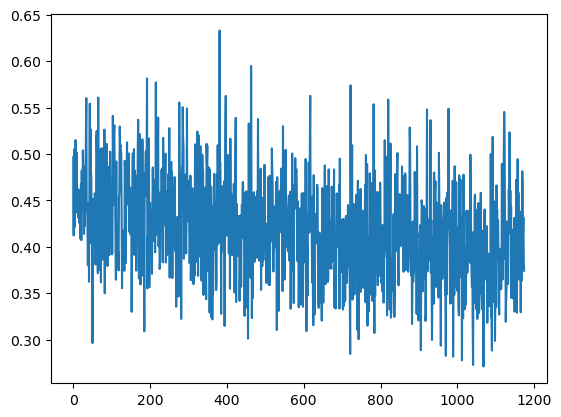

In [180]:
plt.plot(lossi)

In [181]:
# evaluate the accuracy
l, n = 0.0, 0
loss = nn.CrossEntropyLoss(reduction='sum')
for X, y in test_iter:
    logits = net(X)
    l += loss(logits, y)
    n += X.shape[0]

l /= n
print(f'loss in test: {l.item()}')

loss in test: 0.4298092722892761


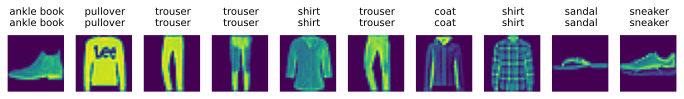

In [186]:
from d2lzh_pytorch import get_fashion_mnist_labels, show_fashion_mnist
import torch.nn.functional as F

with torch.no_grad():
    # prediction
    X, y = iter(test_iter).__next__()
    X = X[:10] ; y = y[:10]
    name = get_fashion_mnist_labels(y)
    
    logits = net(X)
    probs = F.softmax(logits, 1)
    y_hat = probs.argmax(1)
    name_hat = get_fashion_mnist_labels(y_hat)
    
    names = []
    for na, na_hat in zip(name, name_hat):
        names.append(na + '\n' + na_hat)
    
    show_fashion_mnist(X.squeeze(), names)

In [188]:
for p in net.parameters():
    print(p.requires_grad)

True
True
True
True
